In [10]:
import os, sys
import iris
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import timeseries
import general_io as gio
import convenient_universal as uconv

In [11]:
infile_dict = {}
infile_dict['wfo'] = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/wfo/gn/v20191112/wfo_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['masso'] = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/masso/gn/v20191112/masso_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['thetaoga'] = '/g/data/r87/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/thetaoga/gn/v20191112/thetaoga_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['hfds'] = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Omon/hfds/gn/v20191112/hfds_Omon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'
infile_dict['areacello'] = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/Ofx/areacello/gn/v20191112/areacello_Ofx_ACCESS-CM2_piControl_r1i1p1f1_gn.nc'

In [12]:
names = {}
names['hfds'] = 'surface_downward_heat_flux_in_sea_water'
names['wfo'] = 'water_flux_into_sea_water'

In [13]:
area_cube = gio.get_ocean_weights(infile_dict['areacello'])

In [14]:
cp = 3992.10322329649; # J kg-1 degC-1

thetaoga_cube = iris.load_cube(infile_dict['thetaoga'], 'sea_water_potential_temperature')
thetaoga_cube = gio.temperature_unit_check(thetaoga_cube, 'K')
thetaoga_cube = timeseries.convert_to_annual(thetaoga_cube)

masso_cube = iris.load_cube(infile_dict['masso'], 'sea_water_mass')
ref_time_coord = masso_cube.coord('time')
masso_cube = timeseries.convert_to_annual(masso_cube)
masso_anomaly_data = masso_cube.data - masso_cube.data[0]

ohc_data = masso_cube.data * thetaoga_cube.data * cp
ohc_anomaly_data = ohc_data - ohc_data[0]

thetaoga_anomaly_data = thetaoga_cube.data - thetaoga_cube.data[0]
thermal_data = cp * masso_cube.data[0] * thetaoga_anomaly_data

In [15]:
def read_flux_old_method(var, area_cube, annual=True):
    """Read flux data using old method"""
    
    infile = infile_dict[var]
    name = names[var]
    cube = iris.load_cube(infile, name)
    
    if annual:
        # 1. Monthly to annual timescale
        cube = timeseries.convert_to_annual(cube)
    
    # 2. Multiply by area
    area_array = uconv.broadcast_array(area_cube.data, [1, 2], cube.shape)
    assert 'm-2' in str(cube.units)
    cube.units = str(cube.units).replace('m-2', '').replace('  ', ' ')
    cube.data = cube.data * area_array

    # 3. Global sum
    coord_names = [coord.name() for coord in cube.dim_coords]
    cube = cube.collapsed(coord_names[1:], iris.analysis.SUM)

    # 4. Flux to total
    cube = timeseries.flux_to_total(cube)
    
    return cube


def read_flux_new_method(var, area_cube, annual=True):
    """Read flux data using new method"""
    
    infile = infile_dict[var]
    name = names[var]
    cube = iris.load_cube(infile, name)
    
    # 1. Multiply by area
    area_array = uconv.broadcast_array(area_cube.data, [1, 2], cube.shape)
    assert 'm-2' in str(cube.units)
    cube.units = str(cube.units).replace('m-2', '').replace('  ', ' ')
    cube.data = cube.data * area_array

    # 2. Global sum
    coord_names = [coord.name() for coord in cube.dim_coords]
    cube = cube.collapsed(coord_names[1:], iris.analysis.SUM)

    # 3. Flux to total
    cube = timeseries.flux_to_total(cube)
    
    if annual:
        # 4. Monthly to annual timescale
        cube = timeseries.convert_to_annual(cube, aggregation='sum')
    
    return cube


def calc_cumsum(cube):
    """Calculate the cumulative sum"""
    
    cumsum_data = np.cumsum(cube.data)
    cumsum_anomaly = cumsum_data - cumsum_data[0]
    
    return cumsum_anomaly

In [16]:
wfo_old_annual = read_flux_old_method('wfo', area_cube)
wfo_new_annual = read_flux_new_method('wfo', area_cube)

hfds_old_annual = read_flux_old_method('hfds', area_cube)
hfds_new_annual = read_flux_new_method('hfds', area_cube)

#wfo_old_monthly = read_flux_old_method('wfo', area_cube, annual=False)
#wfo_new_monthly = read_flux_new_method('wfo', area_cube, annual=False)

#hfds_old_monthly = read_flux_old_method('hfds', area_cube, annual=False)
#hfds_new_monthly = read_flux_new_method('hfds', area_cube, annual=False)

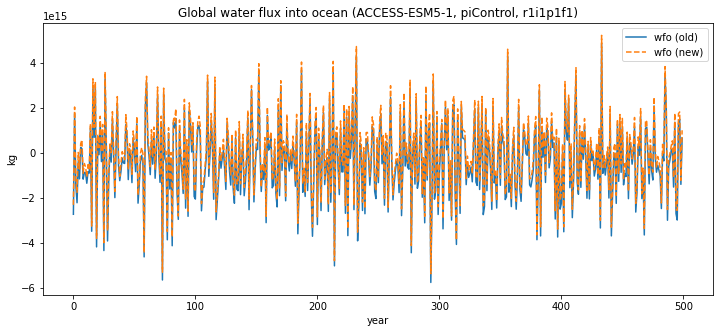

In [17]:
plt.figure(figsize=[12, 5])
plt.plot(wfo_old_annual.data, label='wfo (old)')
plt.plot(wfo_new_annual.data, label='wfo (new)', linestyle='dashed')
plt.ylabel('kg')
plt.xlabel('year')
plt.legend()
plt.title('Global water flux into ocean (ACCESS-ESM5-1, piControl, r1i1p1f1)')
plt.show()

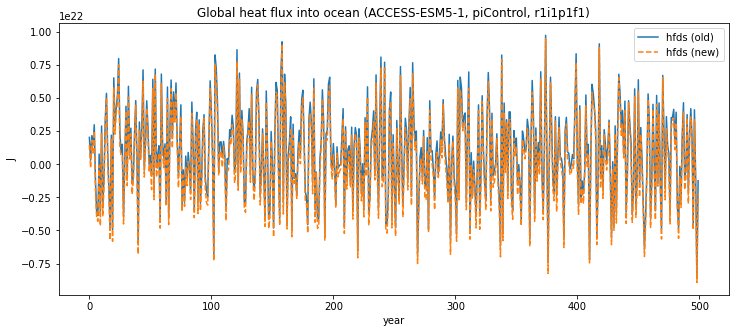

In [18]:
plt.figure(figsize=[12, 5])
plt.plot(hfds_old_annual.data, label='hfds (old)')
plt.plot(hfds_new_annual.data, label='hfds (new)', linestyle='dashed')
plt.ylabel('J')
plt.xlabel('year')
plt.legend()
plt.title('Global heat flux into ocean (ACCESS-ESM5-1, piControl, r1i1p1f1)')
plt.show()

In [19]:
monthly_times = np.arange(0, 500, 1/12)
annual_times = np.arange(0, 500, 1)

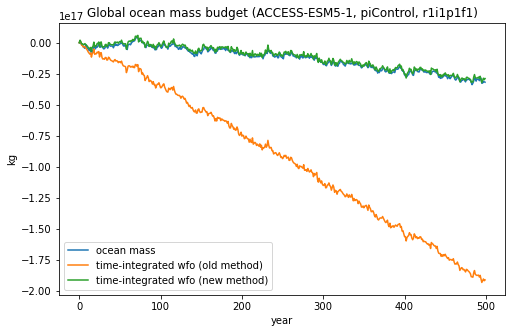

In [20]:
plt.figure(figsize=[8, 5])
#plt.plot(monthly_times, calc_cumsum(wfo_old_monthly), label='time-integrated wfo (old method, monthly)', linestyle='dashed')
#plt.plot(monthly_times, calc_cumsum(wfo_new_monthly), label='time-integrated wfo (new method, monthly)')
plt.plot(masso_anomaly_data, label='ocean mass')
plt.plot(calc_cumsum(wfo_old_annual), label='time-integrated wfo (old method)')
plt.plot(calc_cumsum(wfo_new_annual), label='time-integrated wfo (new method)')
plt.ylabel('kg')
plt.xlabel('year')
plt.legend()
plt.title('Global ocean mass budget (ACCESS-ESM5-1, piControl, r1i1p1f1)')
plt.show()

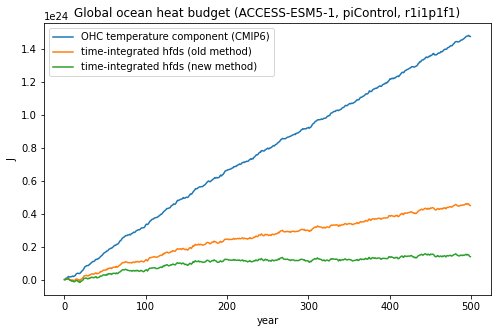

In [23]:
plt.figure(figsize=[8, 5])
plt.plot(thermal_data, label='OHC temperature component (CMIP6)')
plt.plot(calc_cumsum(hfds_old), label='time-integrated hfds (old method)')
plt.plot(calc_cumsum(hfds_new), label='time-integrated hfds (new method)')
plt.ylabel('J')
plt.xlabel('year')
plt.legend()
plt.title('Global ocean heat budget (ACCESS-ESM5-1, piControl, r1i1p1f1)')
plt.show()

Error: Need to convert from monthly to annual last (as a sum of the monthly values) instead of first (as an average flux). The fact that each month has a different number of days matters because the cumulative sum is sensitive.